In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

from stargazer.stargazer import Stargazer

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d38 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_38.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

In [23]:
ed_level.columns

Index(['ElectDist', 'Shape_Leng', 'Shape_Area', 'geometry', 'mhhi21',
       'Agriculture, Forestry, Fishing and Hunting',
       'Mining, Quarrying, and Oil and Gas Extraction', 'Utilities',
       'Construction', 'Manufacturing', 'Wholesale Trade', 'Retail Trade',
       'Transportation and Warehousing', 'Information',
       'Finance and Insurance', 'Real Estate and Rental and Leasing',
       'Professional, Scientific, and Technical Services',
       'Management of Companies and Enterprises',
       'Administrative and Support and Waste Management and Remediation Services',
       'Educational Services', 'Health Care and Social Assistance',
       'Arts, Entertainment, and Recreation',
       'Accommodation and Food Services',
       'Other Services [except Public Administration]',
       'Public Administration', 'nha21p', 'nhb21p', 'nhw21p', 'h21p',
       'cvap21bapp'],
      dtype='object')

In [32]:
d38_eds = d38['ed_name'].unique().tolist()

In [45]:
def make_demo_map(eds_list,demo_df):
    demo_map = demo_df[demo_df['ElectDist'].isin(eds_list)]
    demo_map['geometry'] = demo_map['geometry'].apply(wkt.loads)
    demo_map = gpd.GeoDataFrame(demo_map)
    return demo_map

C:\Users\samtg\AppData\Local\Temp\ipykernel_21264\2425529744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_map['geometry'] = demo_map['geometry'].apply(wkt.loads)


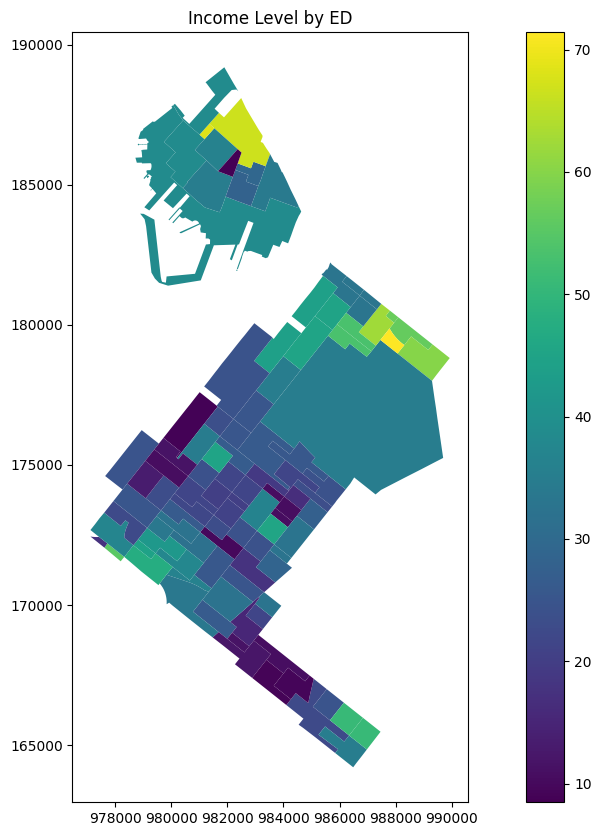

In [54]:
demo_map = make_demo_map(d38_eds,ed_level)
#demo_map = demo_map[demo_map['mhhi21'] < 299999]
demo_map.plot(column='nhw21p', cmap='viridis', legend=True, figsize=(15, 10))
plt.title("Income Level by ED")
plt.show()

In [41]:
demo_map[['ElectDist','mhhi21']].sort_values('mhhi21',ascending=False).head(10)

,ElectDist,mhhi21
2145,51010,572289.285195
2146,51011,351763.525011
2200,51072,344661.616517
1965,49001,286041.499556
1978,49015,265856.141249
5766,51052,256983.359140
5503,49008,242637.969367
2161,51027,236597.967452
2023,49061,228784.974301
2187,51058,214655.822054


In [8]:
full_results_thirty_eight = full_results[full_results['district'] == 38]
frte_winner = full_results_thirty_eight[full_results_thirty_eight['winner'] == True]

In [9]:
full_results_thirty_eight.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Alexa Aviles           4599.0
Yu Lin                 3025.0
Rodrigo G. Camarena    1345.0
Jacqui Painter         1142.0
Cesar Zuniga           1035.0
Victor Swinton          471.0
219518.0                196.0
221151.0                 77.0
221286.0                 46.0
218123.0                 41.0
217777.0                 38.0
overvote                 34.0
Write-in                 32.0
221291.0                 10.0
Name: vote, dtype: float64

In [14]:
d38[d38['district_38_choice_1'] == 'Yu Lin'].groupby('district_38_choice_1')['district_38_choice_2'].value_counts().reset_index(name='count').sort_values('count', ascending=False).head(10)


,district_38_choice_1,district_38_choice_2,count
0,Yu Lin,Alexa Aviles,295
1,Yu Lin,Cesar Zuniga,256
2,Yu Lin,Victor Swinton,179
3,Yu Lin,Jacqui Painter,152
4,Yu Lin,Rodrigo G. Camarena,136
5,Yu Lin,Yu Lin,76
6,Yu Lin,Write-in,7
7,Yu Lin,overvote,3


In [18]:
d38[d38['district_38_choice_1'] == 'Rodrigo G. Camarena'] \
    .groupby('district_38_choice_1')['district_38_choice_2'] \
    .value_counts(dropna=False) \
    .reset_index(name='count') \
    .sort_values('count', ascending=False) \
    .head(10)

,district_38_choice_1,district_38_choice_2,count
0,Rodrigo G. Camarena,Alexa Aviles,589
1,Rodrigo G. Camarena,NaN,292
2,Rodrigo G. Camarena,Cesar Zuniga,227
3,Rodrigo G. Camarena,Jacqui Painter,163
4,Rodrigo G. Camarena,Yu Lin,55
5,Rodrigo G. Camarena,Victor Swinton,50
6,Rodrigo G. Camarena,Rodrigo G. Camarena,12
7,Rodrigo G. Camarena,Write-in,2
8,Rodrigo G. Camarena,overvote,1


In [19]:
frte_winner['candidate'].value_counts() 

candidate
Alexa Aviles           52
Yu Lin                 39
Jacqui Painter          8
Rodrigo G. Camarena     2
Cesar Zuniga            2
Name: count, dtype: int64

In [48]:
frte_winner = frte_winner[['ed_name', 'candidate','geometry']]

In [50]:
frte_winner['geometry'] = frte_winner['geometry'].apply(wkt.loads)
frte_winner = gpd.GeoDataFrame(frte_winner)

In [52]:
frte_winner['candidate'] = frte_winner['candidate'].astype('category')

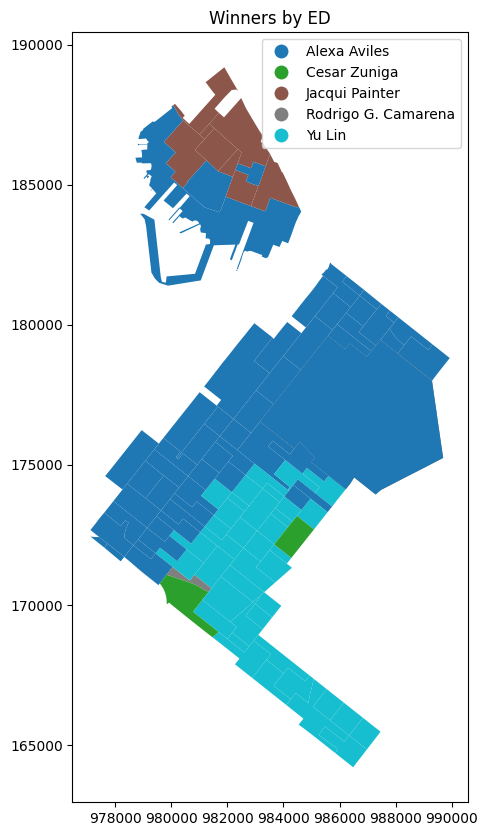

In [53]:
frte_winner.plot(column='candidate', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Winners by ED")
plt.show()